# Loading libraries and dataframe with added locations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn as sk
plt.style.use('ggplot')

In [2]:
df=pd.read_csv('combined_data_with_loc.csv')
df.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947


In [3]:
print(df['Community Name'])

0            Ascot Vale
1             Braybrook
2           Craigieburn
3               Croydon
4               Fawkner
5             Footscray
6               Glenroy
7          Malvern East
8               Malvern
9     Melbourne Airport
10              Mentone
11            Moorabbin
12           Mordialloc
13          Murrumbeena
14           Noble Park
15      North Melbourne
16            Northcote
17            Parkville
18    Pascoe Vale South
19       Port Melbourne
20              Prahran
21           Somerville
22             Sorrento
23      South Melbourne
24          South Yarra
25           Springvale
26     St Andrews Beach
27        St Kilda East
28             St Kilda
29        St Kilda West
30               Toorak
31                Tyabb
32            Waterways
33              Windsor
Name: Community Name, dtype: object


Formatting locational data for downstream tasks

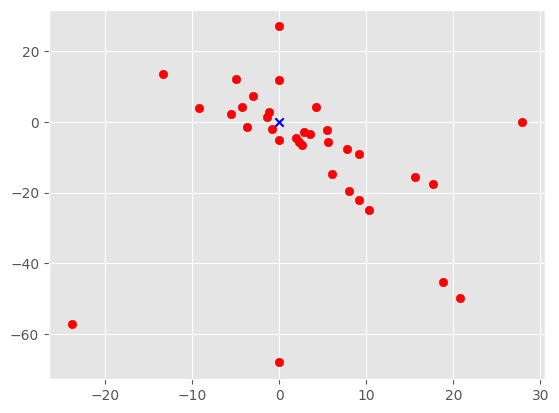

In [4]:
locs=np.asarray(list(zip(df['cart_x'],df['cart_y'])))

# plot locs on a scatter plot, with (0,0) at the center
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(0,0,color='blue', marker='x')
plt.show()


# Beginning The Clustering Process

## Reasoning

Before addressing the hypothesis of "Nearby Suburbs are Similar", we first need to set up clusters of *_nearby_* suburbs. Afterwards, we'll address if the within-cluster locations are similar in nature using the metrics that we'll be defining afterwards.

The reasoning behind this approach is: 

We should not let the similarity metrics derived from the features influence the city-clustering, consciously or subconsciouly. We decide upon what qualifies as the close-by suburbs first, only then we judge upon the goodness of our hypothesis by our defined measures.

## Handling Locationally Outlier Suburbs

We'll decide the 'outliers' in two ways:
1. How far away they are from the origin (Melbourne GPO)
2. How much locally isolated the suburbs are

### 1. Distance from the Origin

We'll analyse the distribution in terms of each of the co-ordinates. We'll consider the suburbs with $(x,y)$ such that

 $x \not\in (Q^x_1-1.5\times IQR_x, Q^x_3+1.5\times IQR_x)$ $\text{OR}$ $y \not\in (Q^y_1-1.5\times IQR_y, Q^y_3+1.5\times IQR_y)$.

as outliers.

However, this is not exactly a good method on its own, since a few far away points from the origin even when clustered together will get rejected. We'll combine approaches 1 and 2. 


DescribeResult(nobs=34, minmax=(array([-23.8364841 , -68.12017913]), array([27.93334923, 27.04969046])), mean=array([ 3.19919332, -8.85161919]), variance=array([ 98.70338635, 416.25255756]), skewness=array([ 0.04737478, -1.29084182]), kurtosis=array([1.01840203, 1.52678611]))
[-1.34419175  2.4833545   7.96892529]
[-15.37890098  -4.08438017   2.65811421]


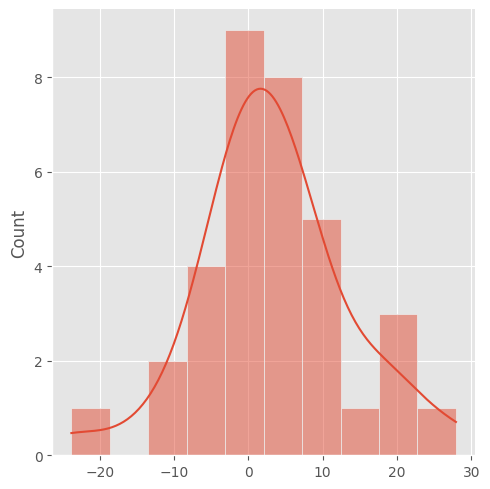

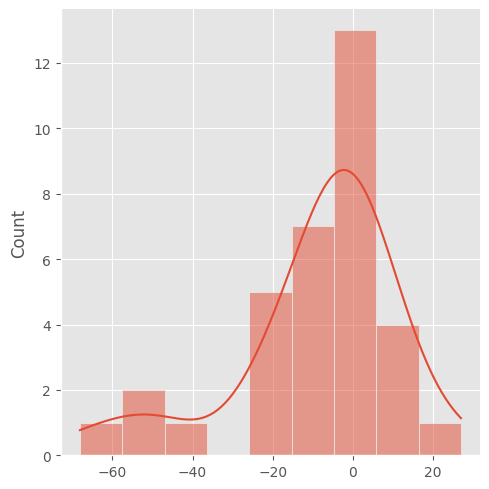

In [5]:
# describe the locational data
import scipy.stats as stats
print(stats.describe(locs))

# print the quartiles for the x and y coordinates
print(np.percentile(locs[:,0], [25, 50, 75]))
print(np.percentile(locs[:,1], [25, 50, 75]))

sns.displot(locs[:,0], kde=True)
plt.show()

sns.displot(locs[:,1], kde=True)
plt.show()




$x$ looks normally distributed, while $y$ does not. We'll test it.

In [6]:
# perform shapiro-wilk test for normality of x and y coordinates
print(stats.shapiro(locs[:,0]))
print(stats.shapiro(locs[:,1]))

# perform anderson-darling test for normality of x and y coordinates
print(stats.anderson(locs[:,0]))
print(stats.anderson(locs[:,1]))


ShapiroResult(statistic=np.float64(0.9670688954563095), pvalue=np.float64(0.3855347856075575))
ShapiroResult(statistic=np.float64(0.8707230058313595), pvalue=np.float64(0.00084308888086645))
AndersonResult(statistic=np.float64(0.5158051454446735), critical_values=array([0.526, 0.599, 0.718, 0.838, 0.996]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.199193322824144), scale=np.float64(9.934957793182829))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=np.float64(1.7286553541403507), critical_values=array([0.526, 0.599, 0.718, 0.838, 0.996]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-8.851619191333763), scale=np.float64(20.4022684415311))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


Both the tests confirm that $x$ is normally distributed and $y$ is not.

While this approach does not serve us too much at this point, it's good to have some idea what we'll be dealing with next.

We'll now visualize the sururbs on a scatterplot.

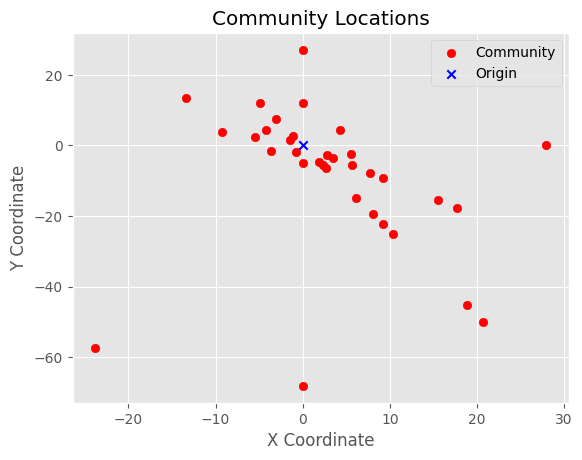

In [7]:
plt.scatter(locs[:,0],locs[:,1],color='red')
# scale the origin as well
origin = np.array([[0,0]])
# origin = scaler.transform(origin)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.legend(['Community','Origin'])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Community Locations')
plt.show()

We now figure out the quartiles and do a boxplot for the same.

DescribeResult(nobs=34, minmax=(array([-23.8364841 , -68.12017913]), array([27.93334923, 27.04969046])), mean=array([ 3.19919332, -8.85161919]), variance=array([ 98.70338635, 416.25255756]), skewness=array([ 0.04737478, -1.29084182]), kurtosis=array([1.01840203, 1.52678611]))
The x quartiles are: [-1.34419175  2.4833545   7.96892529]
The y quartiles are: [-15.37890098  -4.08438017   2.65811421]


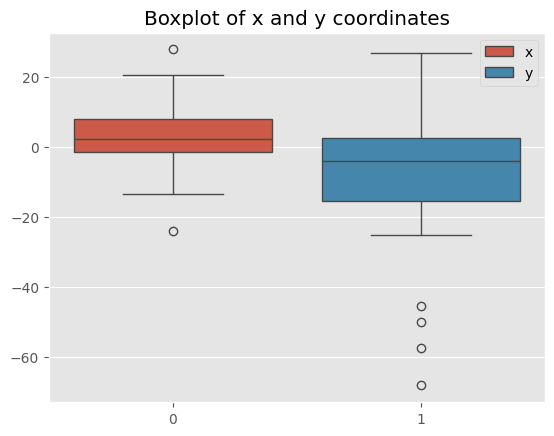

In [8]:
# Determine the distribution of the scaled data
print(stats.describe(locs))

# print the quartiles for the x and y coordinates
print('The x quartiles are:',np.percentile(locs[:,0], [25, 50, 75]))
print('The y quartiles are:',np.percentile(locs[:,1], [25, 50, 75]))

# do a boxplot of the scaled data
sns.boxplot(data=locs)
# show the legend
plt.legend(['x','y'])
plt.title('Boxplot of x and y coordinates')
plt.show()

As can be seen from the boxplot, the $y$ coordinate contains a bit more outliers as compared to $x$.

Number of outliers in x co-ordinate: 2
Number of outliers in y co-ordinate: 4
Total number of outliers (either in x or y): 5


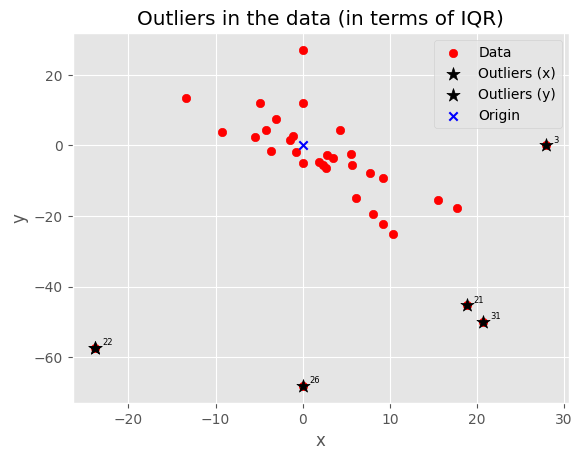

The outlier indices are: [ 3 21 22 26 31]
The corresponding community names are:
 3              Croydon
21          Somerville
22            Sorrento
26    St Andrews Beach
31               Tyabb
Name: Community Name, dtype: object


In [9]:
# count the number of 'outliers' in the scaled data in terms of IQR
# these are the far away points from the main 'mass' of the data
q1_x, q3_x = np.percentile(locs[:,0], [25, 75])
iqr_x = q3_x - q1_x
outliers_x = (locs[:,0] < q1_x - 1.5*iqr_x) | (locs[:,0] > q3_x + 1.5*iqr_x)
print('Number of outliers in x co-ordinate:',np.sum(outliers_x))

q1_y, q3_y = np.percentile(locs[:,1], [25, 75])
iqr_y = q3_y - q1_y
outliers_y = (locs[:,1] < q1_y - 1.5*iqr_y) | (locs[:,1] > q3_y + 1.5*iqr_y)
print('Number of outliers in y co-ordinate:',np.sum(outliers_y))

# count the total number of outliers
print('Total number of outliers (either in x or y):',np.sum(outliers_x | outliers_y))

# highlight the outliers in the scatter plot
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[outliers_x,0],locs[outliers_x,1],color='black', marker='*',s=100)
plt.scatter(locs[outliers_y,0],locs[outliers_y,1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')

# also annotate each outlier with the corresponding index
for i in np.where(outliers_x | outliers_y)[0]:
	plt.annotate(i, (locs[i,0]+.8,locs[i,1]+.8), fontsize=6)

# show the legend
plt.legend(['Data','Outliers (x)','Outliers (y)','Origin'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Outliers in the data (in terms of IQR)')
plt.show()

# print the outlier indices and the corresponding community names
coord_outliers = np.where(outliers_x | outliers_y)[0]
print('The outlier indices are:',coord_outliers)
print('The corresponding community names are:\n',df['Community Name'][coord_outliers])


### 2. Local Density Based Outlier Detection

In [10]:
# do a local outlier factor analysis on the distances
from sklearn.neighbors import LocalOutlierFactor

def get_lof_outliers(n_neighbors, top_k=5):
	lof = LocalOutlierFactor(n_neighbors=n_neighbors)
	lof.fit_predict(locs)
	# get the negative outlier factor
	lof_scores = lof.negative_outlier_factor_

	# pick the top 5 outliers
	top_lof_outliers = np.argsort(lof_scores)[:top_k]
	# print(f'The top 5 outliers detected by LOF with {n_neighbors} neighbors:',top_lof_outliers)
	# print('The corresponding community names are:\n',df['Community Name'][top_lof_outliers])

	return top_lof_outliers

# get the top 5 outliers
top_lof_outliers = get_lof_outliers(7)

print(f'The top 5 outliers detected by LOF with 7 neighbors:',top_lof_outliers)
print('The corresponding community names are:\n',df['Community Name'][top_lof_outliers])




The top 5 outliers detected by LOF with 7 neighbors: [ 3 22 26  2 31]
The corresponding community names are:
 3              Croydon
22            Sorrento
26    St Andrews Beach
2          Craigieburn
31               Tyabb
Name: Community Name, dtype: object


Since LOF is highly sensitive on the choice of $k$, we'll run the algorithm for multiple $k$'s and choose the most frequenty occuring suburbs.

The outliers selected based on max frequency are: [2, 3, 9, 16, 21, 22, 26, 31]
The corresponding community names are:
 2           Craigieburn
3               Croydon
9     Melbourne Airport
16            Northcote
21           Somerville
22             Sorrento
26     St Andrews Beach
31                Tyabb
Name: Community Name, dtype: object


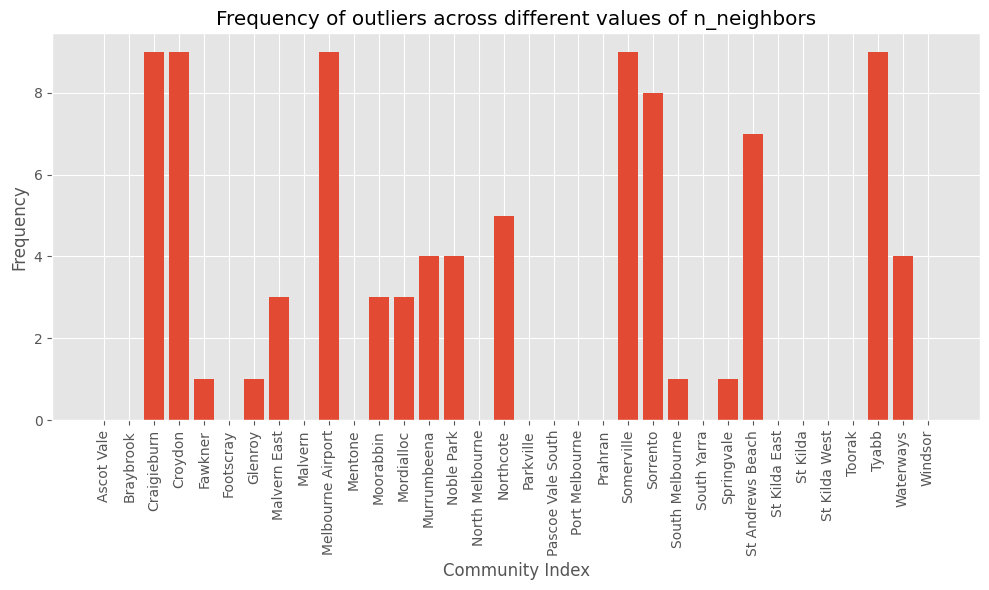

The outliers sorted based on frequency are: [ 0  1  5  8 10 15 18 30 24 27 29 28 20 19 17 33  4 25 23  6 11  7 12 13
 32 14 16 26 22  2  9  3 31 21]
The corresponding community names are:
 0            Ascot Vale
1             Braybrook
5             Footscray
8               Malvern
10              Mentone
15      North Melbourne
18    Pascoe Vale South
30               Toorak
24          South Yarra
27        St Kilda East
29        St Kilda West
28             St Kilda
20              Prahran
19       Port Melbourne
17            Parkville
33              Windsor
4               Fawkner
25           Springvale
23      South Melbourne
6               Glenroy
11            Moorabbin
7          Malvern East
12           Mordialloc
13          Murrumbeena
32            Waterways
14           Noble Park
16            Northcote
26     St Andrews Beach
22             Sorrento
2           Craigieburn
9     Melbourne Airport
3               Croydon
31                Tyabb
21           Somerv

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Different values of n_neighbors to try
n_neighbors = [2, 3, 4, 5, 6, 7, 8, 9, 10]
top_lof_outliers = []

# Function to get outliers for each n_neighbors (assumes the existence of get_lof_outliers)
# get_lof_outliers(n, threshold) returns the indices of the top 'threshold' outliers.
for n in n_neighbors:
	top_lof_outliers.append(get_lof_outliers(n, 10))

# Count the frequency of each outlier across all values of n_neighbors
outlier_freq = np.zeros(len(locs))
for outlier_list in top_lof_outliers:
	for outlier in outlier_list:
		outlier_freq[outlier] += 1

# Select outliers that have the highest frequencies
# For example, we can choose outliers that appear in more than half of the n_neighbors runs
threshold = len(n_neighbors) // 2
max_freq_outliers = [i for i, freq in enumerate(outlier_freq) if freq > threshold]

# Print the selected outliers based on their frequency
print('The outliers selected based on max frequency are:', max_freq_outliers)
print('The corresponding community names are:\n', df['Community Name'][max_freq_outliers])

# Plot the frequency of each outlier
plt.figure(figsize=(10, 6))
plt.bar(range(len(outlier_freq)), outlier_freq)
plt.xlabel('Community Index')
plt.ylabel('Frequency')
plt.title('Frequency of outliers across different values of n_neighbors')
plt.xticks(range(len(locs)), df['Community Name'], rotation=90)
plt.tight_layout()
plt.show()

sorted_outlier_freq = np.argsort(outlier_freq)
print('The outliers sorted based on frequency are:', sorted_outlier_freq)
print('The corresponding community names are:\n', df['Community Name'][sorted_outlier_freq])

# select the top 8 outliers based on frequency
top_freq_outliers_LOF = sorted_outlier_freq[-8:]


Text(0.5, 0, 'x')

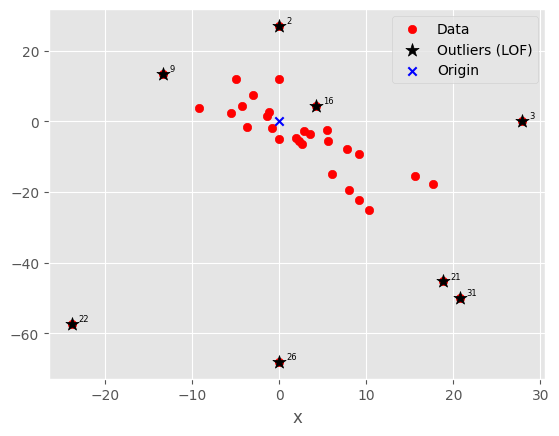

In [12]:
# plot the outliers detected by LOF
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[list(top_freq_outliers_LOF),0],locs[list(top_freq_outliers_LOF),1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')

# also annotate each outlier with the corresponding index
for i in top_freq_outliers_LOF:
	plt.annotate(i, (locs[i,0]+.8,locs[i,1]+.8), fontsize=6)

# show the legend
plt.legend(['Data','Outliers (LOF)','Origin'])
plt.xlabel('x')


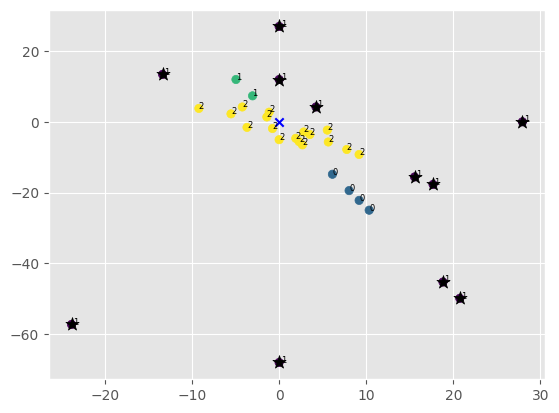

Number of clusters: 4
Number of noise points: 11


In [13]:
# Now do HDBSCAN clustering on the locational data

import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, min_samples=2)
clusterer.fit(locs)

# plot the clusters
plt.scatter(locs[:,0],locs[:,1],c=clusterer.labels_)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
# highlight the noise points
plt.scatter(locs[clusterer.labels_==-1,0],locs[clusterer.labels_==-1,1],color='black', marker='*',s=100)
# annotate each point with the corresponding cluster label
for i in range(len(locs)):
	plt.annotate(clusterer.labels_[i], (locs[i,0],locs[i,1]), size=6)

plt.show()
print('Number of clusters:',len(np.unique(clusterer.labels_)))
print('Number of noise points:',np.sum(clusterer.labels_==-1))

# get the indices of the noise points
noise_points_hdbscan = np.where(clusterer.labels_==-1)[0]

The noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=1: [ 1  2  3  8  9 16 30]
The corresponding community names are:
 1             Braybrook
2           Craigieburn
3               Croydon
8               Malvern
9     Melbourne Airport
16            Northcote
30               Toorak
Name: Community Name, dtype: object
Too many noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=2: [ 2  3  4  9 14 16 21 22 25 26 31]
Skipping these parameters...
Too many noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=3: [ 2  3  4  6  9 12 14 21 22 25 26 31 32]
Skipping these parameters...
Too many noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=4: [ 1  2  3  4  5  6  7  9 10 11 12 13 14 16 17 18 19 21 22 25 26 30 31 32]
Skipping these parameters...
Too many noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=5: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24

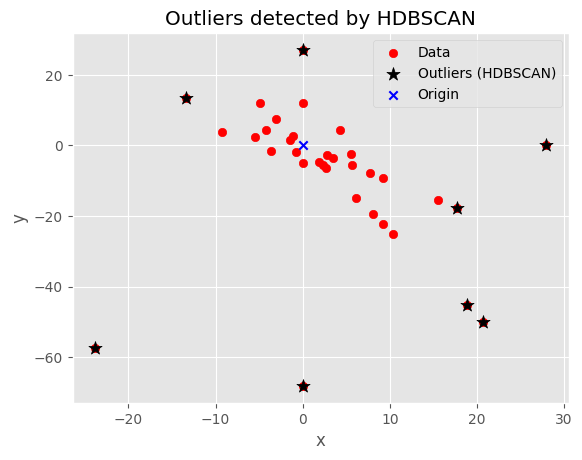

In [14]:
# define a function to get the outliers based on HDBSCAN
def get_hdbscan_outliers(min_cluster_size, min_samples):
	clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
	clusterer.fit(locs)
	# get the noise points
	noise_points_hdbscan = np.where(clusterer.labels_==-1)[0]
	return noise_points_hdbscan, len(noise_points_hdbscan)/len(locs)

# get the outliers based on HDBSCAN
hdbscan_outliers = []

# Example: Different values of min_cluster_size and min_samples to try
min_cluster_sizes = [2, 3, 4, 5]
min_samples = [1, 2, 3, 4, 5]


noise_count_threshold = 0.3
for i in min_cluster_sizes:
	for j in min_samples:
		noise_points_hdbscan, noise_ratio = get_hdbscan_outliers(i, j)
		# accept only if the algo does not classify too many points as noise
		if noise_ratio < noise_count_threshold:
			hdbscan_outliers.append(noise_points_hdbscan)
			print(f'The noise points detected by HDBSCAN with min_cluster_size={i} and min_samples={j}:',noise_points_hdbscan)
			print('The corresponding community names are:\n',df['Community Name'][noise_points_hdbscan])

		else:
			print(f'Too many noise points detected by HDBSCAN with min_cluster_size={i} and min_samples={j}:',noise_points_hdbscan)
			print('Skipping these parameters...')


print('The outliers detected by HDBSCAN are:',hdbscan_outliers)

majority_hdbscan_outliers = np.zeros(len(locs))

for i in range(len(hdbscan_outliers)):
	for outlier in hdbscan_outliers[i]:
		majority_hdbscan_outliers[outlier] += 1

# Select outliers that have the highest frequencies
# sort the outliers based on frequency
sorted_majority_hdbscan_outliers = np.argsort(majority_hdbscan_outliers)
print('The outliers sorted based on frequency are:', sorted_majority_hdbscan_outliers)
print('The corresponding community names are:\n', df['Community Name'][sorted_majority_hdbscan_outliers][::-1])

# select the top 8 outliers based on frequency
top_freq_outliers_HDBSCAN = sorted_majority_hdbscan_outliers[-8:]

# plot the outliers detected by HDBSCAN
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[list(top_freq_outliers_HDBSCAN),0],locs[list(top_freq_outliers_HDBSCAN),1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.legend(['Data','Outliers (HDBSCAN)','Origin'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Outliers detected by HDBSCAN')
plt.show()



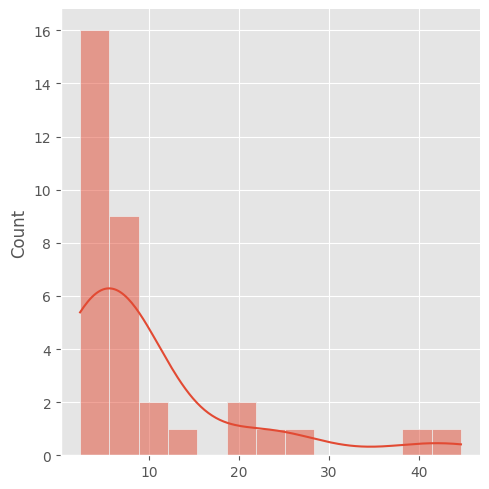

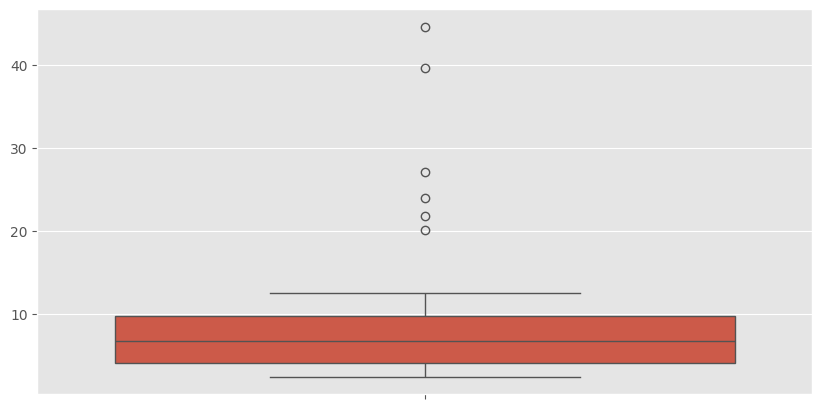

Number of outliers in terms of average distances: 6
Indices of the outliers: [ 2  3 21 22 26 31]
Threshold distance: 18.2589496219338


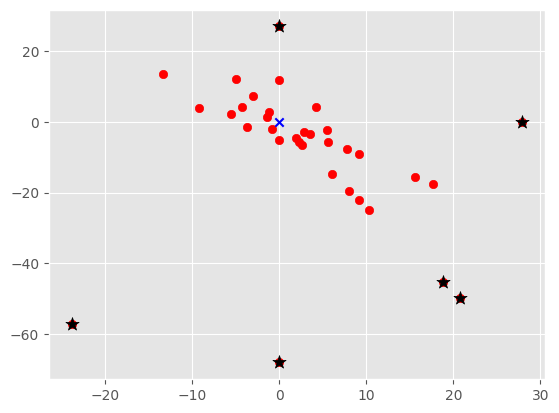

In [15]:
# Now, do the following: For each point take the top 5 nearest neighbors and calculate the average distance
# to these neighbors. Then, plot the histogram of these average distances.
# We will use the KDTree for this purpose
from scipy.spatial import KDTree
tree = KDTree(locs)
# get the 6 nearest neighbors (including the point itself)
distances, indices = tree.query(locs, k=8)
# calculate the average distance to the 5 nearest neighbors
avg_distances = np.mean(distances[:,1:], axis=1)
# plot the histogram of the average distances
sns.displot(avg_distances, kde=True)
plt.show()

# boxplot of the average distances
plt.figure(figsize=(10,5))
sns.boxplot(data=avg_distances)
plt.show()


# Find out the points for which the average distance to the 5 nearest neighbors is very high

IQR=np.percentile(avg_distances, [25, 75])
IQR_dist = IQR[1] - IQR[0]

threshold = IQR[1] + 1.5*IQR_dist
outliers_avg_dist = avg_distances > threshold
print('Number of outliers in terms of average distances:',np.sum(outliers_avg_dist))
print('Indices of the outliers:',np.where(outliers_avg_dist)[0])
print('Threshold distance:',threshold)

# highlight the outliers in the scatter plot
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[outliers_avg_dist,0],locs[outliers_avg_dist,1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.show()

In [16]:
# define a function to get the outliers based on average distances using the KDTree with varying k

def get_avg_dist_outliers(k):
	# threshold will be the 1.5*IQR above the 75th percentile
	distances, indices = tree.query(locs, k=k)
	# calculate the average distance to the k-1 nearest neighbors
	avg_distances = np.mean(distances[:,1:], axis=1)
	IQR=np.percentile(avg_distances, [25, 75])
	IQR_dist = IQR[1] - IQR[0]
	threshold = IQR[1] + 1.5*IQR_dist
	outliers_avg_dist = avg_distances > threshold
	# return the indices of the outliers
	return np.where(outliers_avg_dist)[0]

# get the outliers for k=6
outliers_avg_dist_k6 = get_avg_dist_outliers(6)
print('The outliers detected by average distance with k=6:',outliers_avg_dist_k6)

The outliers detected by average distance with k=6: [ 2  3 21 22 26 31]


In [17]:
# run the function for different values of k
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
outliers_avg_dist = []
for k in k_values:
	outliers_avg_dist.append(get_avg_dist_outliers(k))

# Count the frequency of each outlier across all values of k
outlier_freq = np.zeros(len(locs))
for outlier_list in outliers_avg_dist:
	for outlier in outlier_list:
		outlier_freq[outlier] += 1

# Select outliers that have the highest frequencies
# For example, we can choose outliers that appear in more than half of the k runs
threshold = len(k_values) // 2
max_freq_outliers = [i for i, freq in enumerate(outlier_freq) if freq > threshold]

top_kdtree_count=8
# argsort the outlier frequencies
sorted_outlier_freq = np.argsort(outlier_freq)
print('The outliers sorted based on frequency are:', sorted_outlier_freq[-top_kdtree_count:])
print('The corresponding community names are:\n', df['Community Name'][sorted_outlier_freq[-top_kdtree_count:]])


The outliers sorted based on frequency are: [33 32 21  2 31  3 26 22]
The corresponding community names are:
 33             Windsor
32           Waterways
21          Somerville
2          Craigieburn
31               Tyabb
3              Croydon
26    St Andrews Beach
22            Sorrento
Name: Community Name, dtype: object


In [18]:
# count the votes for each outlier from the different methods
# we will count the votes for each outlier from the different methods
votes = np.zeros(len(locs))
# add the votes from the LOF method
for outlier in top_freq_outliers_LOF:
	votes[outlier] += 1
# add the votes from the HDBSCAN method
for outlier in top_freq_outliers_HDBSCAN:
	votes[outlier] += 1

# add the votes from the KDTree method
for outlier in sorted_outlier_freq[-top_kdtree_count:]:
	votes[outlier] += 1

# add the votes from coordinate outliers
for outlier in coord_outliers:
	votes[outlier] += 1
	

print('The votes for each outlier are:',votes)

# select the outliers that have the most votes
threshold = 2
final_outliers = np.where(votes >= threshold)[0]
print('The final outliers are:',final_outliers)
print('The corresponding community names are:\n',df['Community Name'][final_outliers])

The votes for each outlier are: [0. 0. 3. 4. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 4. 4. 0.
 0. 0. 4. 0. 0. 0. 0. 4. 1. 1.]
The final outliers are: [ 2  3  9 21 22 26 31]
The corresponding community names are:
 2           Craigieburn
3               Croydon
9     Melbourne Airport
21           Somerville
22             Sorrento
26     St Andrews Beach
31                Tyabb
Name: Community Name, dtype: object


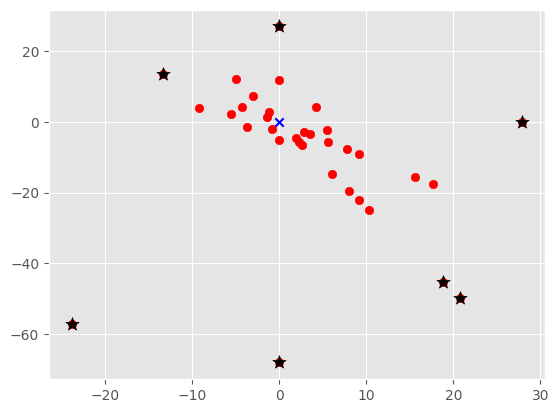

In [19]:
# plot the final outliers
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[final_outliers,0],locs[final_outliers,1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.show()

In [20]:
final_outliers

array([ 2,  3,  9, 21, 22, 26, 31])

The mapping of the indices between the original and the filtered data is: [ 0  1  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 23 24 25 27 28 29
 30 32 33]


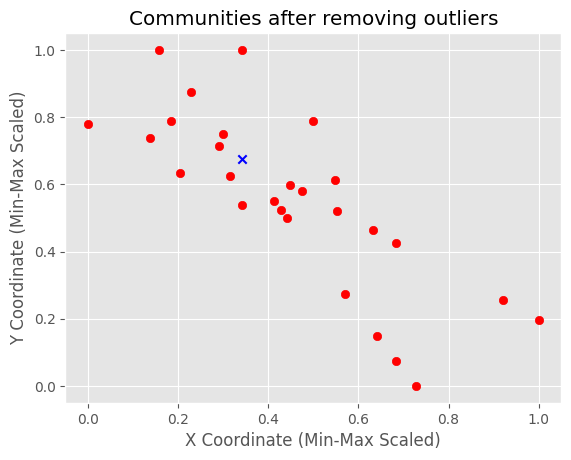

In [21]:
# drop the outliers and re-run the clustering
locs_filtered = np.delete(locs, final_outliers, axis=0)
# find out the mapping of the indices between the original and the filtered data
mapping = np.arange(len(locs))
mapping = np.delete(mapping, final_outliers)
map_dict = {i: mapping[i] for i in range(len(mapping))}
print('The mapping of the indices between the original and the filtered data is:',mapping)
# re-scale the points
scaler_filtered = sk.preprocessing.MinMaxScaler()
locs_filtered = scaler_filtered.fit_transform(locs_filtered)
# re-scale the origin
origin_scaled = scaler_filtered.transform(origin)
# clusterer_filtered = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, min_samples=1, cluster_selection_epsilon=0.5)
# clusterer_filtered.fit(locs_filtered)

# plot the clusters
plt.scatter(locs_filtered[:,0],locs_filtered[:,1],color='red')
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# highlight the noise points
# plt.scatter(locs_filtered[clusterer_filtered.labels_==-1,0],locs_filtered[clusterer_filtered.labels_==-1,1],color='black', marker='*',s=100)
# # annotate each point with the corresponding cluster label
# for i in range(len(locs_filtered)):
# 	plt.annotate(clusterer_filtered.labels_[i], (locs_filtered[i,0],locs_filtered[i,1]), size=6)

plt.title('Communities after removing outliers')
plt.xlabel('X Coordinate (Min-Max Scaled)')
plt.ylabel('Y Coordinate (Min-Max Scaled)')
plt.show()


Eigenvalues of the Laplacian matrix: [-0.65353254 -0.19974157 -0.14598048  0.75934639  0.85092938  1.58578644
  1.60050314  1.70495999  2.1914881   2.50500569  2.92890093  3.
  3.25565865  3.34155213  3.57695626  3.71698248  4.          4.1604903
  4.30212027  4.34283181  4.41421356  4.64236773  4.67291129  4.82194819
  5.09363941  5.24351808  5.28714435]


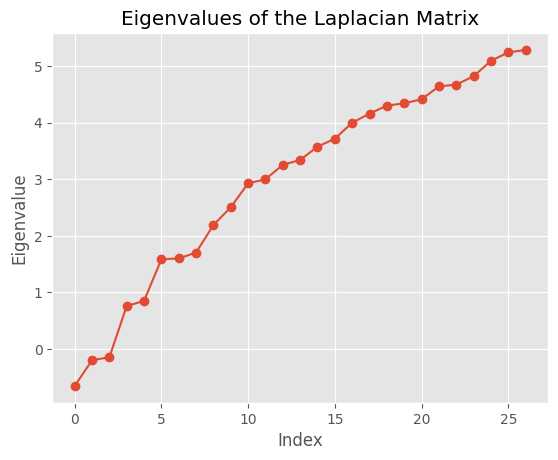

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize
from scipy.linalg import eigh
from sklearn.metrics import pairwise_distances

# Assume locs_filtered contains your filtered location data (e.g., latitude and longitude)
# Generate the affinity matrix using nearest neighbors
n_neighbors = 4  # Same as used in SpectralClustering
affinity_matrix = kneighbors_graph(locs_filtered, n_neighbors=n_neighbors, include_self=True).toarray()

# Compute the Laplacian matrix (unnormalized or normalized)
from sklearn.metrics.pairwise import pairwise_kernels
laplacian = np.diag(np.sum(affinity_matrix, axis=1)) - affinity_matrix

# Eigen decomposition of the Laplacian matrix
# eigh returns sorted eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(laplacian)

# Output the eigenvalues
print("Eigenvalues of the Laplacian matrix:", eigenvalues)

# Optional: Visualize the first few eigenvectors if needed
plt.plot(eigenvalues, marker='o')
plt.title('Eigenvalues of the Laplacian Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()


The indices of the largest jumps in eigenvalues are: [np.int64(18), np.int64(15), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2)]


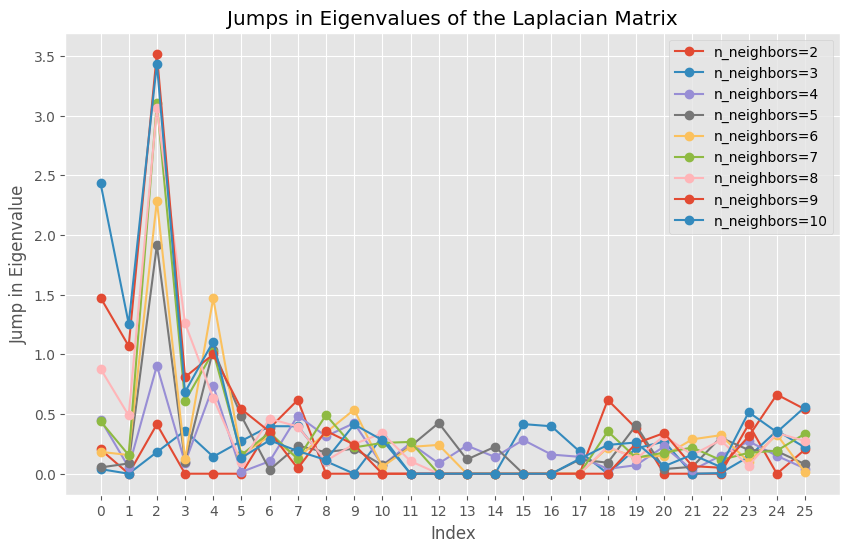

The most common index with the largest jump in eigenvalues is: 2
The optimal number of clusters is: 3


In [23]:
# define a function to get the jump in eigenvalues, with varying n_neighbors
def get_eigenvalue_jump(n_neighbors):
	affinity_matrix = kneighbors_graph(locs_filtered, n_neighbors=n_neighbors, include_self=True).toarray()
	laplacian = np.diag(np.sum(affinity_matrix, axis=1)) - affinity_matrix
	eigenvalues, eigenvectors = eigh(laplacian)
	# sort the eigenvalues
	eigenvalues = np.sort(eigenvalues)
	# get the jump in eigenvalues
	jumps = np.diff(eigenvalues)
	return jumps

# get the jump in eigenvalues for different values of n_neighbors
n_neighbors_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
eigenvalue_jumps = []
for n in n_neighbors_values:
	eigenvalue_jumps.append(get_eigenvalue_jump(n))

# figure out where the jump in eigenvalues is the largest for each n_neighbors
max_jumps = [np.argmax(jumps) for jumps in eigenvalue_jumps]
print('The indices of the largest jumps in eigenvalues are:',max_jumps)

# plot the jumps in eigenvalues for each n_neighbors
plt.figure(figsize=(10, 6))
for i in range(len(n_neighbors_values)):
	plt.plot(eigenvalue_jumps[i], marker='o', label=f'n_neighbors={n_neighbors_values[i]}')
plt.title('Jumps in Eigenvalues of the Laplacian Matrix')
plt.xlabel('Index')
plt.ylabel('Jump in Eigenvalue')
plt.xticks(range(len(eigenvalue_jumps[0])), range(0, len(eigenvalue_jumps[0])))
plt.legend()
plt.show()

# count how many times each index was the maximum jump
max_jumps = np.array(max_jumps)
unique, counts = np.unique(max_jumps, return_counts=True)
max_jumps = dict(zip(unique, counts))

# get the index with the most number of times as the maximum jump
most_common_index = max(max_jumps, key=max_jumps.get)
print('The most common index with the largest jump in eigenvalues is:',most_common_index)

# print the conclusion in terms of optimal cluster number
print('The optimal number of clusters is:',most_common_index+1)


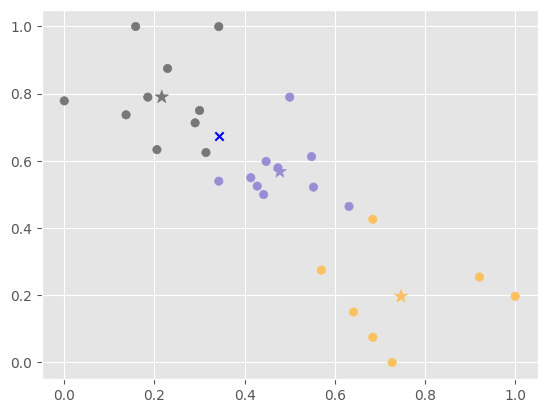

In [24]:
# run spectral clustering on the locational data
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=5)
spectral.fit(locs_filtered)

# plot the clusters
plt.scatter(locs_filtered[:,0],locs_filtered[:,1],c=[f'C{label+9}' for label in spectral.labels_])
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# plot the centroids_spectral
centroids_spectral = np.zeros((3,2))
for i in range(3):
	centroids_spectral[i] = np.mean(locs_filtered[spectral.labels_==i], axis=0)
plt.scatter(centroids_spectral[:,0],centroids_spectral[:,1],color=[f'C{i+9}' for i in range(3)],marker='*',s=100)
plt.show()



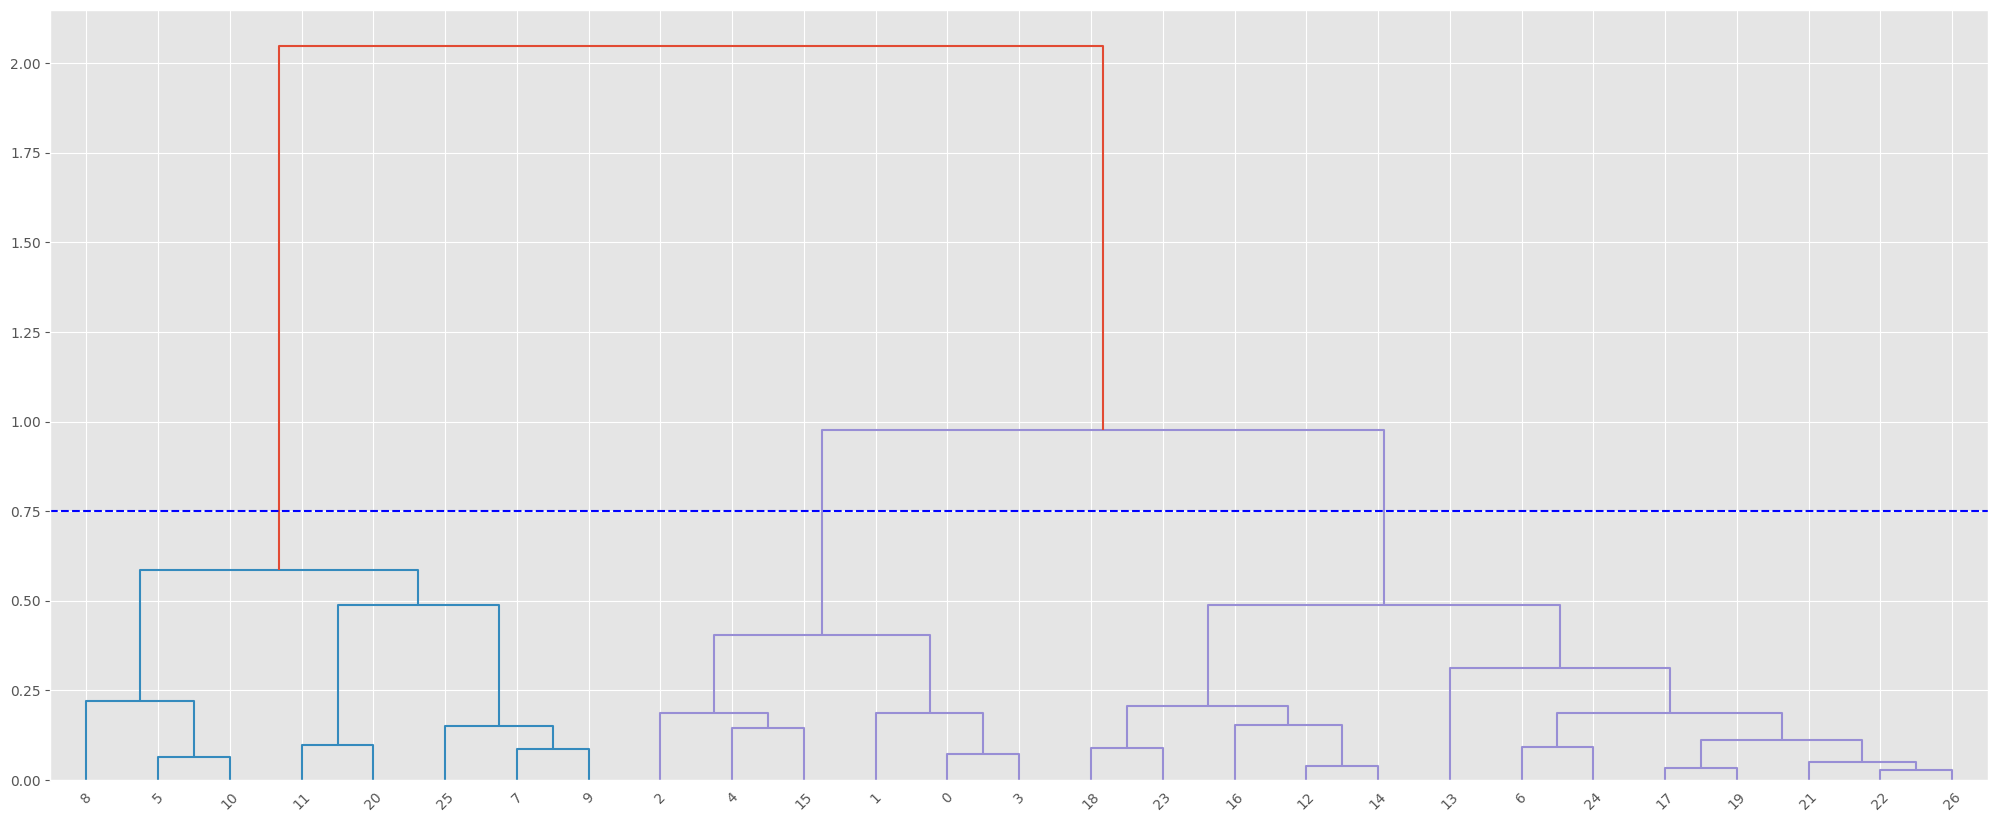

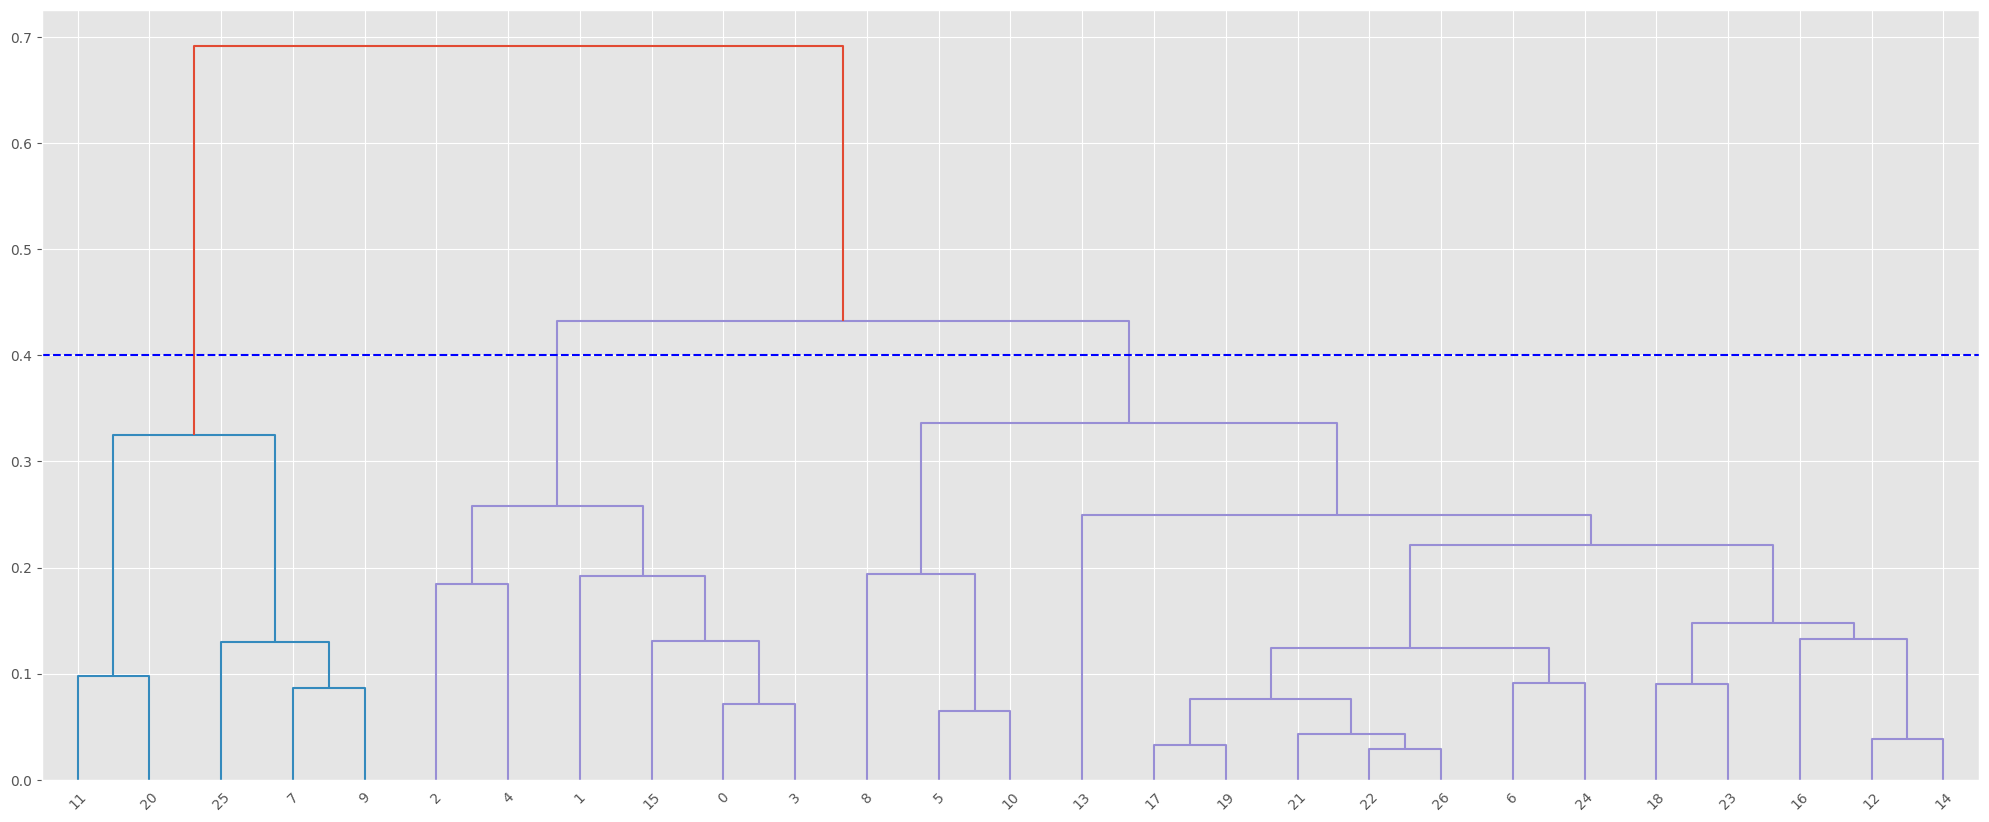

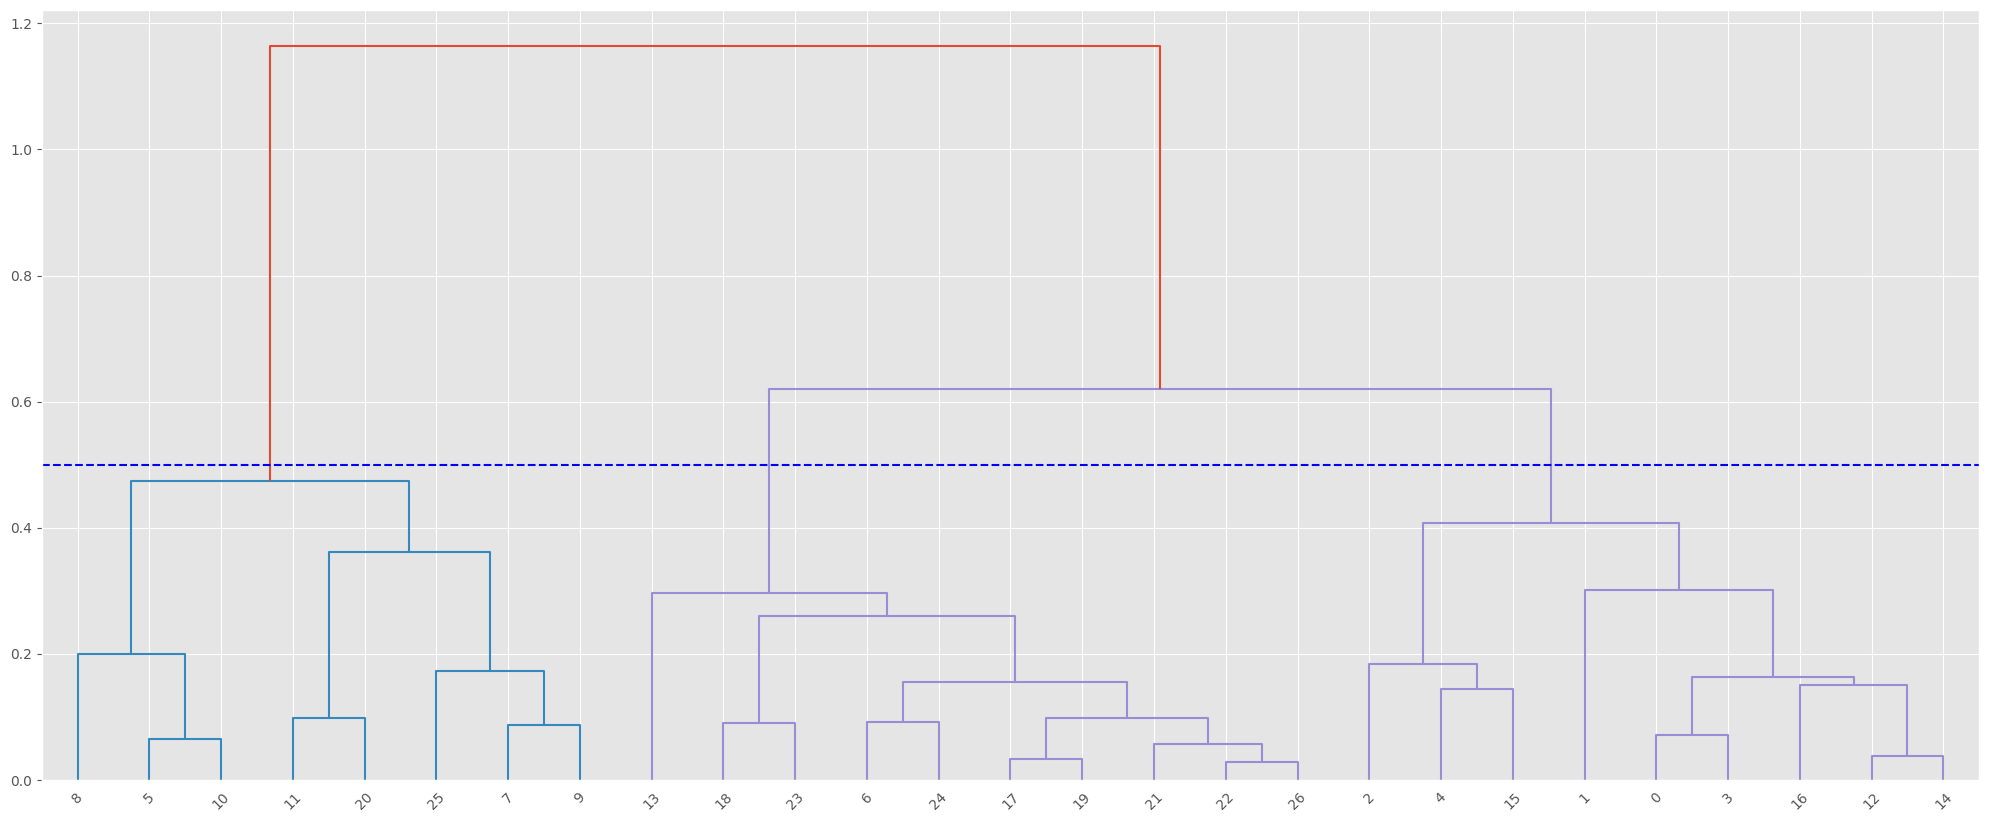

In [25]:
# show the dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(locs_filtered, 'ward')
plt.figure(figsize=(25, 10))
dendrogram(Z)
# draw a horizontal line at y=0.75
plt.axhline(y=0.75, color='b', linestyle='--')
plt.show()

# show linkage based on average distance
Z_avg = linkage(locs_filtered, 'average')
plt.figure(figsize=(25, 10))
dendrogram(Z_avg)
# draw a horizontal line at y=0.4
plt.axhline(y=0.4, color='b', linestyle='--')
plt.show()

# show linkage based on complete distance
Z_complete = linkage(locs_filtered, 'complete')
plt.figure(figsize=(25, 10))
dendrogram(Z_complete)
# draw a horizontal line at y=0.4
plt.axhline(y=0.5, color='b', linestyle='--')
plt.show()

The evaluation scores for linkage method ward are: (np.float64(0.42891505703300786), np.float64(43.925218257190586), np.float64(0.7228103287362657))
The evaluation scores for linkage method average are: (np.float64(0.4093166316098958), np.float64(38.82666206310298), np.float64(0.6658820996022748))
The evaluation scores for linkage method complete are: (np.float64(0.4330650163524465), np.float64(46.927149134938276), np.float64(0.6838891392113616))
The evaluation scores for linkage method single are: (np.float64(0.5011298901486023), np.float64(20.60055963150351), np.float64(0.4921914330865163))


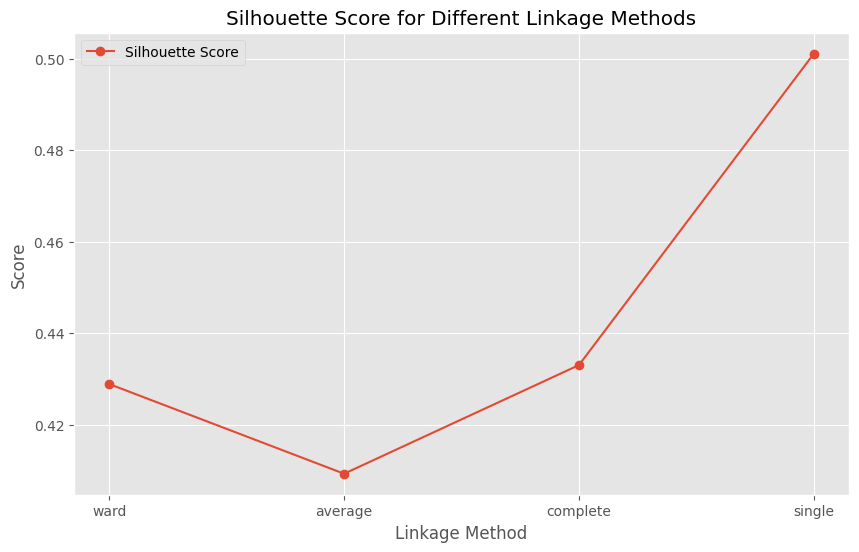

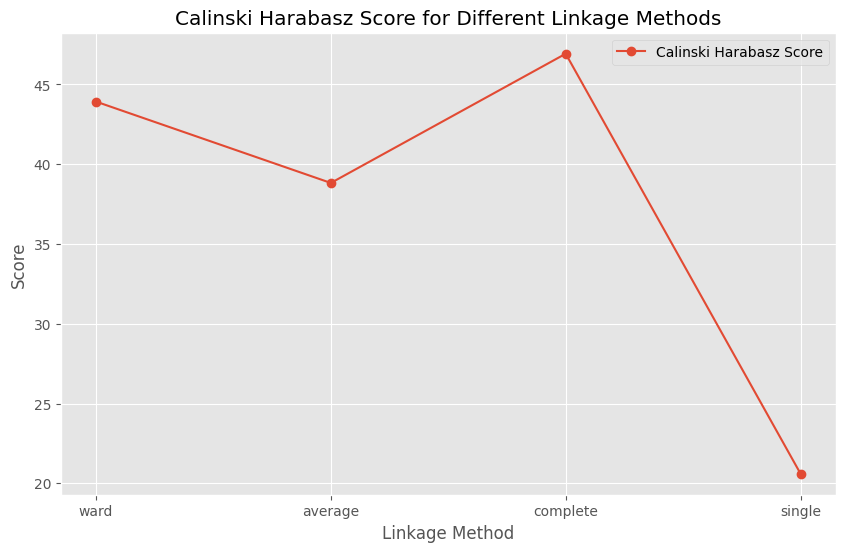

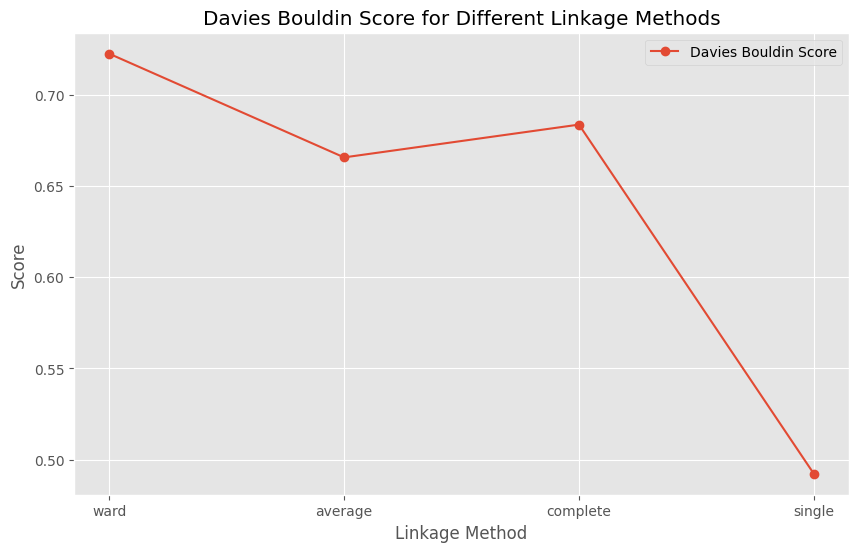

The silhouette ranking is: ['single' 'complete' 'ward' 'average']
The calinski ranking is: ['complete' 'ward' 'average' 'single']
The DBI ranking is: ['single' 'average' 'complete' 'ward']


In [26]:
# Evaluate the different linkage methods using
# silhouette score, calinski harabasz score, and davies bouldin score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

# define a function to evaluate the different linkage methods
def evaluate_linkage(linkage_method):
	# fit the agglomerative clustering model
	agg = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
	agg.fit(locs_filtered)
	# get the silhouette score
	silhouette = silhouette_score(locs_filtered, agg.labels_)
	# get the calinski harabasz score
	calinski = calinski_harabasz_score(locs_filtered, agg.labels_)
	# get the davies bouldin score
	davies = davies_bouldin_score(locs_filtered, agg.labels_)
	return silhouette, calinski, davies

# evaluate the different linkage methods
linkage_methods = ['ward', 'average', 'complete', 'single']
evaluation_scores = []
for method in linkage_methods:
	evaluation_scores.append(evaluate_linkage(method))

# print the evaluation scores
for i in range(len(linkage_methods)):
	print(f'The evaluation scores for linkage method {linkage_methods[i]} are:',evaluation_scores[i])

# plot the evaluation scores
silhouette_scores = [score[0] for score in evaluation_scores]
calinski_scores = [score[1] for score in evaluation_scores]
davies_scores = [score[2] for score in evaluation_scores]

plt.figure(figsize=(10, 6))
plt.plot(linkage_methods, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Linkage Method')
plt.ylabel('Score')
plt.title('Silhouette Score for Different Linkage Methods')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(linkage_methods, calinski_scores, marker='o', label='Calinski Harabasz Score')
plt.xlabel('Linkage Method')
plt.ylabel('Score')
plt.title('Calinski Harabasz Score for Different Linkage Methods')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(linkage_methods, davies_scores, marker='o', label='Davies Bouldin Score')
plt.xlabel('Linkage Method')
plt.ylabel('Score')
plt.title('Davies Bouldin Score for Different Linkage Methods')
plt.legend()
plt.show()



# generate rankings based on the evaluation scores
silhouette_ranking = np.argsort(silhouette_scores)
calinski_ranking = np.argsort(calinski_scores)
davies_ranking = np.argsort(davies_scores)

# print the rankings, with the names of the linkage methods
linkage_methods = np.array(linkage_methods)
print('The silhouette ranking is:',linkage_methods[silhouette_ranking][::-1])
print('The calinski ranking is:',linkage_methods[calinski_ranking][::-1])
print('The DBI ranking is:',linkage_methods[davies_ranking])


In [27]:
# Define the rankings for each metric
silhouette_ranking = ['single', 'complete', 'ward', 'average']
calinski_ranking = ['complete', 'ward', 'average', 'single']
dbi_ranking = ['single', 'average', 'complete', 'ward']

# Combine rankings into a list for easier iteration
rankings = [silhouette_ranking, calinski_ranking, dbi_ranking]

# Initialize a dictionary to store the scores for each method
scores = {'single': 0, 'complete': 0, 'ward': 0, 'average': 0}

# Assign points based on rankings (1 point for best, 2 for second, etc.)
for ranking in rankings:
    for position, method in enumerate(ranking):
        scores[method] += (position + 1)  # position + 1 gives 1 for the first rank, 2 for the second, etc.

# Find the minimum score
min_score = min(scores.values())

# Find all methods that have the minimum score
best_methods = [method for method, score in scores.items() if score == min_score]

# Print the scores and the best methods
print("Scores for each method:")
for method, score in scores.items():
    print(f"{method}: {score}")

# Display the best methods
if len(best_methods) > 1:
    print(f"\nThe best overall methods are (tied): {', '.join(best_methods)} ### with a score of {min_score}")
else:
    print(f"\nThe best overall method is: {best_methods[0]} with a score of {min_score}")


Scores for each method:
single: 6
complete: 6
ward: 9
average: 9

The best overall methods are (tied): single, complete ### with a score of 6


From the scores, we want to try out two linkage methods with 3 clusters: 

*complete* and *single*

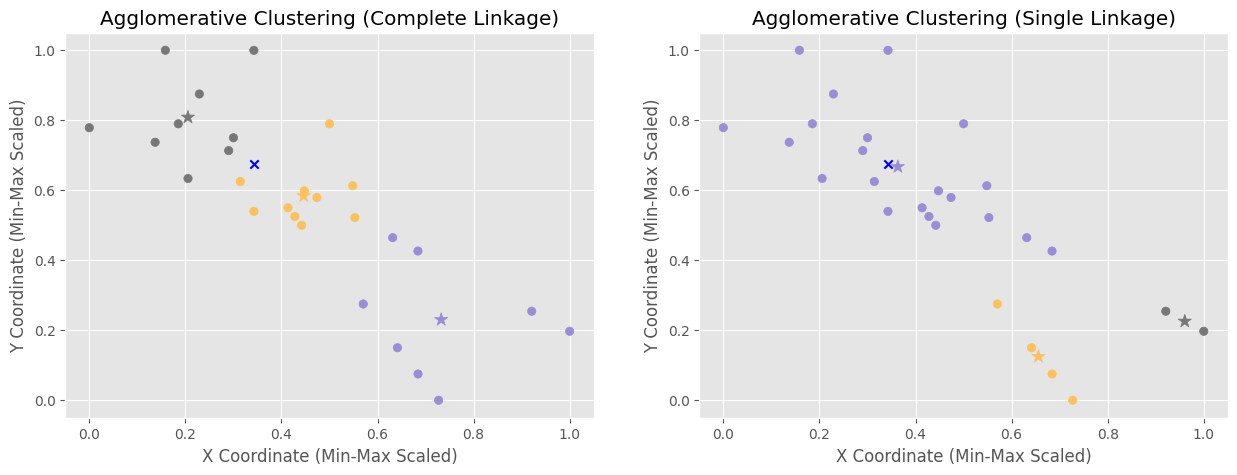

The bincount of the labels for complete linkage is: [ 8  9 10]
The bincount of the labels for single linkage is: [21  2  4]


In [28]:
# try hierarchical clustering on the filtered locational data
from sklearn.cluster import AgglomerativeClustering
agg_complete = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='euclidean')
agg_complete.fit(locs_filtered)

agg_single = AgglomerativeClustering(n_clusters=3, linkage='single', metric='euclidean')
agg_single.fit(locs_filtered)

# create a plot conisting of 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plot the clusters
axs[0].scatter(locs_filtered[:,0],locs_filtered[:,1],c=[f'C{label+9}' for label in agg_complete.labels_])
axs[0].scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# plot the centroids_agg_complete
centroids_agg_complete = np.zeros((3,2))
for i in range(3):
	centroids_agg_complete[i] = np.mean(locs_filtered[agg_complete.labels_==i], axis=0)
axs[0].scatter(centroids_agg_complete[:,0],centroids_agg_complete[:,1],color=[f'C{i+9}' for i in range(3)],marker='*',s=100)
axs[0].set_title('Agglomerative Clustering (Complete Linkage)')
axs[0].set_xlabel('X Coordinate (Min-Max Scaled)')
axs[0].set_ylabel('Y Coordinate (Min-Max Scaled)')
# plot the clusters
axs[1].scatter(locs_filtered[:,0],locs_filtered[:,1],c=[f'C{label+9}' for label in agg_single.labels_])
axs[1].scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# plot the centroids_agg_single
centroids_agg_single = np.zeros((3,2))
for i in range(3):
	centroids_agg_single[i] = np.mean(locs_filtered[agg_single.labels_==i], axis=0)
axs[1].scatter(centroids_agg_single[:,0],centroids_agg_single[:,1],color=[f'C{i+9}' for i in range(3)],marker='*',s=100)
axs[1].set_title('Agglomerative Clustering (Single Linkage)')
axs[1].set_xlabel('X Coordinate (Min-Max Scaled)')
axs[1].set_ylabel('Y Coordinate (Min-Max Scaled)')
plt.show()

# print the bincount of the labels
print('The bincount of the labels for complete linkage is:',np.bincount(agg_complete.labels_))
print('The bincount of the labels for single linkage is:',np.bincount(agg_single.labels_))



As can be seen, although single linkage produces very well separated clusters, it is not ideal for our analysis, as this essentially clumps $77\%$ of the points into a single group. In contrast, complete linkage produces very balanced output. 

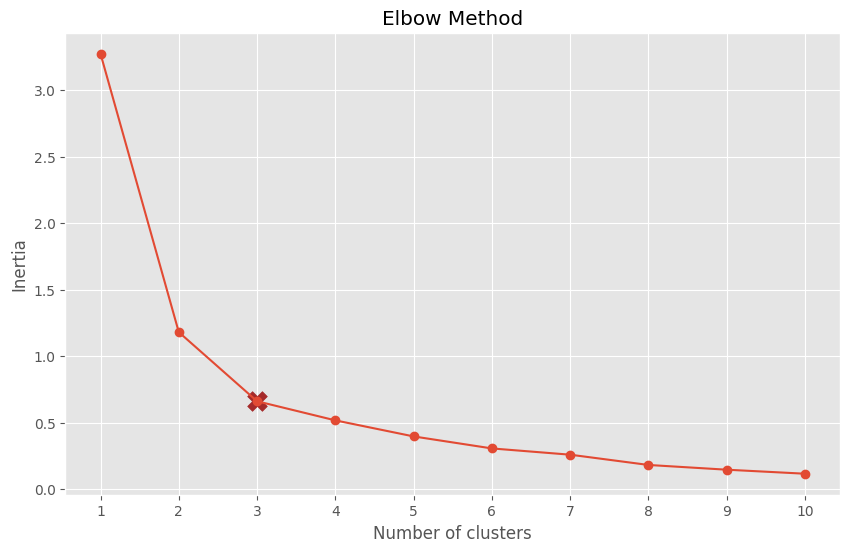

In [29]:
# try k-means clustering on the filtered locational data
from sklearn.cluster import KMeans
# run elbow method to determine the optimal number of clusters
inertia = []
for i in range(1, 11):
	kmeans = KMeans(n_clusters=i, random_state=0).fit(locs_filtered)
	inertia.append(kmeans.inertia_)

# try different themes

plt.figure(figsize=(10, 6))

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))

# place a cross at the optimal number of clusters
plt.scatter(3, inertia[2], color='brown', marker='X', s=200)
plt.show()




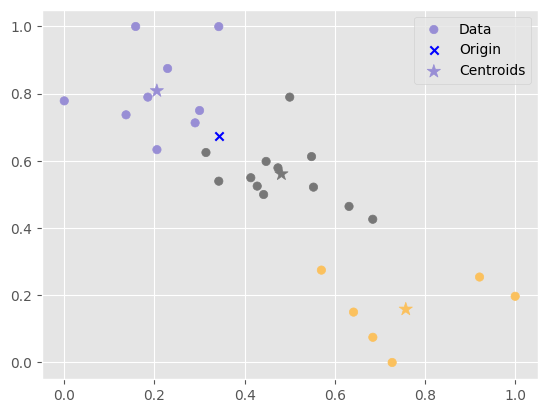

In [30]:
# try k-means clustering on the filtered locational data
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init=100)
kmeans.fit(locs_filtered)


plt.scatter(locs_filtered[:,0],locs_filtered[:,1],c=[f'C{label+9}' for label in kmeans.labels_])
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# show the centroids
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color=[f'C{i+9}' for i in range(3)],marker='*',s=100)

plt.legend(['Data','Origin','Centroids'])
plt.show()


### Agreement between clusterings

In [31]:
agg=agg_complete
# compute NMI between the hierarchical clustering and the k-means clustering
from sklearn.metrics.cluster import normalized_mutual_info_score
nmi = normalized_mutual_info_score(agg.labels_, kmeans.labels_)
print('NMI between hierarchical clustering and k-means clustering:',nmi)


# compute NMI between the hierarchical clustering and the spectral clustering
nmi = normalized_mutual_info_score(agg.labels_, spectral.labels_)
print('NMI between hierarchical clustering and spectral clustering:',nmi)

# compute NMI between the k-means clustering and the spectral clustering
nmi = normalized_mutual_info_score(kmeans.labels_, spectral.labels_)
print('NMI between k-means clustering and spectral clustering:',nmi)



NMI between hierarchical clustering and k-means clustering: 0.8297872676023633
NMI between hierarchical clustering and spectral clustering: 0.7831224705508028
NMI between k-means clustering and spectral clustering: 0.7771705617887947


In [32]:
# Compute ARI between the hierarchical clustering and the k-means clustering
from sklearn.metrics.cluster import adjusted_rand_score
ari = adjusted_rand_score(agg.labels_, kmeans.labels_)
print('ARI between hierarchical clustering and k-means clustering:',ari)

# Compute ARI between the hierarchical clustering and the spectral clustering
ari = adjusted_rand_score(agg.labels_, spectral.labels_)
print('ARI between hierarchical clustering and spectral clustering:',ari)

# Compute ARI between the k-means clustering and the spectral clustering
ari = adjusted_rand_score(kmeans.labels_, spectral.labels_)
print('ARI between k-means clustering and spectral clustering:',ari)

ARI between hierarchical clustering and k-means clustering: 0.7913043478260869
ARI between hierarchical clustering and spectral clustering: 0.7749236166119724
ARI between k-means clustering and spectral clustering: 0.7662337662337663


In [33]:
agg.labels_, kmeans.labels_, spectral.labels_

(array([1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 2,
        2, 2, 2, 0, 2]),
 array([0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 2, 1,
        1, 1, 1, 2, 1], dtype=int32),
 array([1, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 0, 1, 0, 2, 0,
        0, 0, 0, 2, 0], dtype=int32))

### Hungarian Method for label-matching

The best matching between the cluster labels (spectral and k-means) is: [0 1 2] [1 0 2]
The best matching between the cluster labels (hierarchical and k-means) is: [0 1 2] [2 0 1]
The best matching between the cluster labels (hierarchical and spectral) is: [0 1 2] [2 1 0]
{0: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 1: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 2: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 3: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 4: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 5: [np.float64(1.0), np.float64(1.0), np.float64(2.0)], 6: [np.float64(1.0), np.float64(1.0), np.float64(1.0)], 7: [np.float64(2.0), np.float64(2.0), np.float64(2.0)], 8: [np.float64(2.0), np.float64(2.0), np.float64(2.0)], 9: [np.float64(2.0), np.float64(2.0), np.float64(2.0)], 10: [np.float64(2.0), np.float64(1.0), np.float64(2.0)], 11: [np.float64(2.0), np.float64(2.0), np.float64(2.0)], 12: [np.float64(0.0), np.float64(0.0), np.float64(0.

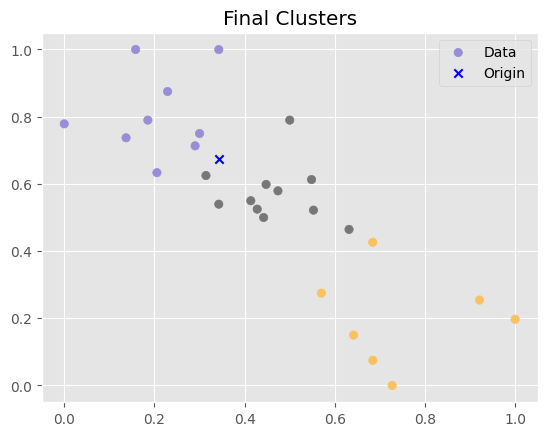

In [34]:
# do a majority voting to get the final cluster labels
votes = np.zeros(len(locs_filtered))
# do hungarian matching to get the best matching between the cluster labels
from scipy.optimize import linear_sum_assignment
# create a cost matrix
cost_matrix_spec_kmeans = np.zeros((3,3))
for i in range(3):
	for j in range(3):
		cost_matrix_spec_kmeans[i,j] = np.sum((spectral.labels_ == i) & (kmeans.labels_ == j))

row_ind_spec_kmeans, col_ind_spec_kmeans = linear_sum_assignment(-cost_matrix_spec_kmeans)
print('The best matching between the cluster labels (spectral and k-means) is:',row_ind_spec_kmeans, col_ind_spec_kmeans)

# do hungarian matching between hierarchical clustering and k-means clustering
# get the best matching between the cluster labels

cost_matrix_hier_kmeans = np.zeros((3,3))
for i in range(3):
	for j in range(3):
		cost_matrix_hier_kmeans[i,j] = np.sum((agg.labels_ == i) & (kmeans.labels_ == j))

row_ind_hier_kmeans, col_ind_hier_kmeans = linear_sum_assignment(-cost_matrix_hier_kmeans)
print('The best matching between the cluster labels (hierarchical and k-means) is:',row_ind_hier_kmeans, col_ind_hier_kmeans)

# do hungarian matching between hierarchical clustering and spectral clustering
# get the best matching between the cluster labels

cost_matrix_hier_spec = np.zeros((3,3))
for i in range(3):
	for j in range(3):
		cost_matrix_hier_spec[i,j] = np.sum((agg.labels_ == i) & (spectral.labels_ == j))

row_ind_hier_spec, col_ind_hier_spec = linear_sum_assignment(-cost_matrix_hier_spec)
print('The best matching between the cluster labels (hierarchical and spectral) is:',row_ind_hier_spec, col_ind_hier_spec)

# get the final cluster labels
final_labels = np.zeros(len(locs_filtered))
# remapped labels for spectral clustering
spectral_labels_remapped = np.zeros(3)
for i in range(3):
	spectral_labels_remapped[i] = col_ind_spec_kmeans[i]

# remapped labels for k-means clustering
kmeans_labels_remapped = np.zeros(3)
for i in range(3):
	kmeans_labels_remapped[i] = row_ind_spec_kmeans[i]

# remapped labels for hierarchical clustering
hier_labels_remapped = np.zeros(3)
for i in range(3):
	hier_labels_remapped[i] = col_ind_hier_kmeans[i]

vote_count_dict = {i:[] for i in range(locs_filtered.shape[0])}
# get the final cluster labels
for i in range(locs_filtered.shape[0]):
	vote_count_dict[i].append(spectral_labels_remapped[spectral.labels_[i]])
	vote_count_dict[i].append(kmeans_labels_remapped[kmeans.labels_[i]])
	vote_count_dict[i].append(hier_labels_remapped[agg.labels_[i]])


print(vote_count_dict)

# get the final cluster labels
for i in range(locs_filtered.shape[0]):
	final_labels[i] = max(vote_count_dict[i], key=vote_count_dict[i].count)

print(final_labels)

# plot the final clusters
plt.scatter(locs_filtered[:,0],locs_filtered[:,1],c=[f'C{int(label)+9}' for label in final_labels])
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
plt.title('Final Clusters')
plt.legend(['Data','Origin'])
plt.show()


In [35]:
final_labels

array([0., 0., 0., 0., 0., 1., 1., 2., 2., 2., 2., 2., 0., 1., 0., 0., 0.,
       1., 1., 1., 2., 1., 1., 1., 1., 2., 1.])

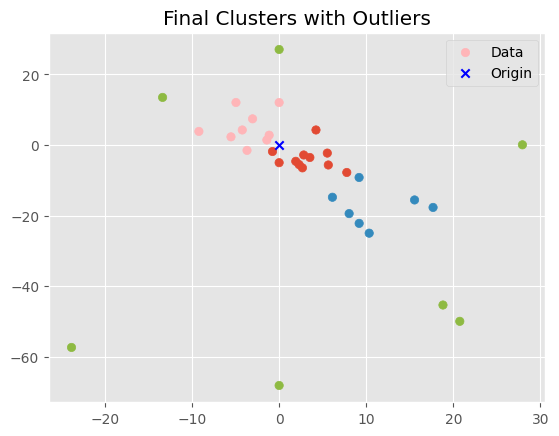

In [36]:
# assign the final cluster labels to the original data
# get the final cluster labels
final_labels_orig = np.zeros(len(locs))
for i in range(len(final_labels)):
	final_labels_orig[map_dict[i]] = final_labels[i]

# assign the outlier labels
for outlier in final_outliers:
	final_labels_orig[outlier] = -1

# plot the final clusters
plt.scatter(locs[:,0],locs[:,1],c=[f'C{int(label)+6}' for label in final_labels_orig])
plt.scatter(0,0,color='blue', marker='x')
plt.title('Final Clusters with Outliers')
plt.legend(['Data','Origin'])
plt.show()

In [37]:
# save the final cluster labels to a csv file
df['Cluster Label'] = final_labels_orig.astype(int)
df.to_csv('final_clusters.csv', index=False)

df.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y,Cluster Label
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470,0
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001,0
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690,-1
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723,-1
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947,0


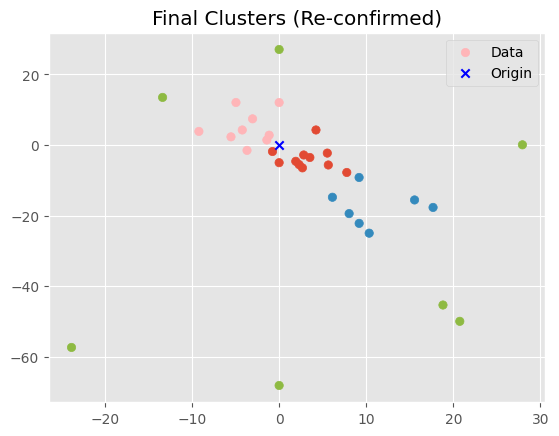

Cluster bin counts: {1: 11, 0: 9, -1: 7, 2: 7}


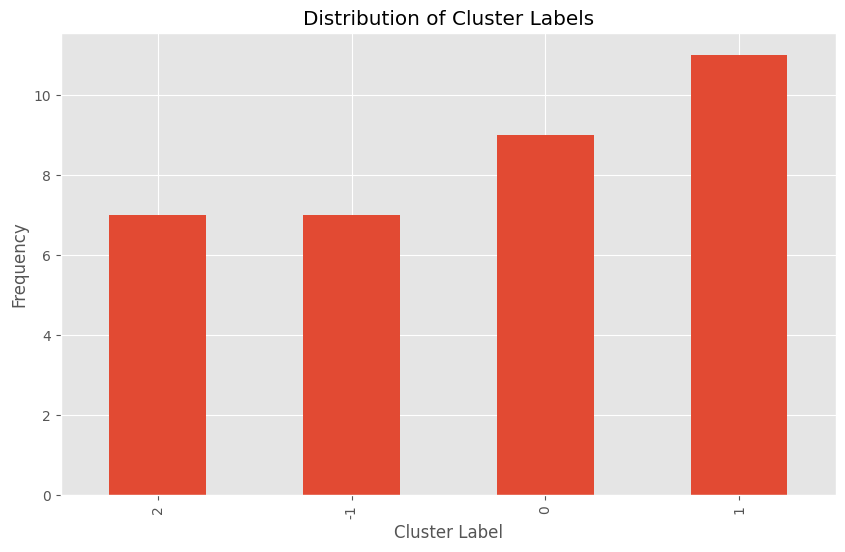

In [38]:
df_clustered = pd.read_csv('final_clusters.csv')

# re-confirm the final clusters
plt.scatter(df_clustered['cart_x'],df_clustered['cart_y'],c=[f'C{int(label)+6}' for label in df_clustered['Cluster Label']])
plt.scatter(0,0,color='blue', marker='x')
plt.title('Final Clusters (Re-confirmed)')
plt.legend(['Data','Origin'])
plt.show()

# print the bin counts
print('Cluster bin counts:',df_clustered['Cluster Label'].value_counts().to_dict())

# plot the distribution of the cluster labels
plt.figure(figsize=(10, 6))
# plot histogram in ascending order of frequency
df_clustered['Cluster Label'].value_counts().sort_values().plot(kind='bar')
plt.xlabel('Cluster Label')
plt.ylabel('Frequency')
plt.title('Distribution of Cluster Labels')
plt.show()